# Ridge regression - Ames Housing Dataset

This notebook is using simple, automated feature selection techniques and Ridge regression on Ames Housing Dataset.

In [1]:
import pandas as pd
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

df = pd.read_csv('AmesHousing.tsv', delimiter='\t')
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Data cleaning

In [2]:
mv = df.isna().sum().sort_values(ascending=False)
print('Percentage and amount of missing values in numerical features')
mv = pd.merge(mv[mv>0].rename('mv #').to_frame(), (mv/len(df)*100).rename('mv %').to_frame(), left_index=True, right_index=True)
mv

Percentage and amount of missing values in numerical features


,mv #,mv %
Pool QC,2917,99.556314
Misc Feature,2824,96.382253
Alley,2732,93.242321
Fence,2358,80.477816
Fireplace Qu,1422,48.532423
Lot Frontage,490,16.723549
Garage Cond,159,5.426621
Garage Finish,159,5.426621
Garage Yr Blt,159,5.426621
Garage Qual,159,5.426621


There are huge amounts of missing values. Let's take a closer look.

We'll combine information about NaN's with value counts and the popularity of the most frequent value in given column.

In [3]:
new = {}
for col in mv.index:
    new[col] = {'unique values': len(df[col].value_counts()),
                'most popular value': df[col].value_counts().index[0],
                'frequency in %': df[col].value_counts().values[0]/len(df)*100}

In [4]:
mv_summary = pd.merge(mv, pd.DataFrame(new).T, left_index=True, right_index=True, how='outer')
print('Categorical and discrete, numerical features')
display(mv_summary[mv_summary['unique values']<10])

Categorical and discrete, numerical features


,mv #,mv %,unique values,most popular value,frequency in %
Pool QC,2917,99.556314,4,Ex,0.136519
Misc Feature,2824,96.382253,5,Shed,3.242321
Alley,2732,93.242321,2,Grvl,4.095563
Fence,2358,80.477816,4,MnPrv,11.262799
Fireplace Qu,1422,48.532423,5,Gd,25.392491
Garage Cond,159,5.426621,5,TA,90.955631
Garage Finish,159,5.426621,3,Unf,42.013652
Garage Qual,159,5.426621,5,TA,89.249147
Garage Type,157,5.358362,6,Attchd,59.078498
Bsmt Exposure,83,2.832765,4,No,65.051195


Acording to the [documantation](https://s3.amazonaws.com/dq-content/307/data_description.txt), NaN's in all categorical features displayed above (except 'Mas Vnr Type' and 'Electrical') indicate the lack of a certain quality (e.g. basement, alley access, pool, garage). We may ignore those for now and treat as meaningful values. We'll also ignore some inconsistencies among this data (eg. Garage Type has 157 missing values, while rest of garage columns 159).

The single NaN value, found in the 'Electrical' feature, can be replaced with its mode - 'SBrkr' that has over 90% of occurances.

Three numerical, discrete features, 'Bsmt Half Bath', 'Bsmt Full Bath', 'Garage Cars', have very little missing values with their modes having very high popularity. These NaN's we'll replace with those values - respectively 0, 0 and 2.

'Mas Vnr Type' is the only feature with no strategy for missing values replacement that has left. We'll leave it for now.

In [5]:
print('Continues, numerical features')
display(mv_summary[mv_summary['unique values']>=10])

Continues, numerical features


,mv #,mv %,unique values,most popular value,frequency in %
Lot Frontage,490,16.723549,128.0,60.0,9.419795
Garage Yr Blt,159,5.426621,103.0,2005.0,4.846416
Mas Vnr Area,23,0.784983,445.0,0.0,59.658703
BsmtFin SF 1,1,0.034130,995.0,0.0,31.740614
Total Bsmt SF,1,0.034130,1058.0,0.0,2.696246
Bsmt Unf SF,1,0.034130,1137.0,0.0,8.327645
BsmtFin SF 2,1,0.034130,274.0,0.0,87.986348
Garage Area,1,0.034130,603.0,0.0,5.358362


We can see that 'Mas Vnr Area' has the same amount of missing values as 'Mas Vnr Type' from the previous table. We'll replace them with modes, respectively 0.0 and 'None', assuming that there was simply no masonry veneer on those buildings.

'Lot Frontage' has significant amount of NaN's. We'll impute them with np.mean for now to see if the column carry some usefull information for the model.

'Garage Yr Blt', the only discrete feature in this list, will be eventually dropped. It could be used as the approximation of the quality and condition of a garage, but we already have such features in this dataset, so there is no need to replace NaN's in there.

We might guess that there was no basement in the property described by the single row with missing values in basement columns. Let's double check it against other features describing basements.

In [6]:
basement_cols = ['Bsmt Qual',
                 'Bsmt Cond',
                 'Bsmt Exposure',
                 'BsmtFin Type 1',
                 'BsmtFin SF 1',
                 'BsmtFin Type 2',
                 'BsmtFin SF 2',
                 'Bsmt Unf SF',
                 'Total Bsmt SF',
                 'Bsmt Full Bath',
                 'Bsmt Half Bath']
display(df[basement_cols][df['BsmtFin SF 1'].isna()])

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
1341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Indeed, as we said before, NaN in 'Bsmt Qual' means 'No basement'. We'll replace these missing values in numerical columns with 0.0.

## Feature extraction

We'll drop information about the sale type, condition and time, because of a possible data leakage, but let's first use the 'Yr Sold' column to compute the age of the building, and time passed since remodelling.

We can also drop 'Year Built' and 'Year Remod/Add' now.
'Order' and 'PID' columns will be removed as they don't carry any information.

In [7]:
df['Years Since Remod'] = df['Yr Sold'] - df['Year Remod/Add']
df['Age'] = df['Yr Sold'] - df['Year Built']

drop_feat = ['Garage Yr Blt',
             'Sale Type',
             'Sale Condition',
             'Yr Sold',
             'Mo Sold',
             'Year Built',
             'Year Remod/Add',
             'Order',
             'PID']
mv_means = ['Lot Frontage', 'Garage Area']
mv_modes = ['Mas Vnr Type', 'Garage Cars', 'Electrical']
mv_zeros = ['Mas Vnr Area',
            'BsmtFin SF 1',
            'BsmtFin SF 2',
            'Bsmt Unf SF',
            'Total Bsmt SF',
            'Bsmt Full Bath',
            'Bsmt Half Bath']

for col in mv_means:
    df[col] =  df[col].fillna(df[col].mean())
for col in mv_zeros:
    df[col] =  df[col].fillna(0)
for col in mv_modes:
    df[col] =  df[col].fillna(df[col].mode()[0])

df = (df.fillna('No')
      .drop(drop_feat, axis=1))

## Feature selection

### Let's examin correlations between numerical features and 'SalePrice'

In [8]:
price_cor = (df.select_dtypes('number')
             .corr()['SalePrice']
             .abs()
             .sort_values(ascending=False)
             .rename('Correlations with target var.')
             .to_frame())
display(price_cor[price_cor>.4].dropna())

,Correlations with target var.
SalePrice,1.000000
Overall Qual,0.799262
Gr Liv Area,0.706780
Garage Cars,0.647812
Garage Area,0.640385
Total Bsmt SF,0.632529
1st Flr SF,0.621676
Age,0.558907
Full Bath,0.545604
Years Since Remod,0.534940


The threshold of 0.4 might be changed later if necessary. Let's see if there is a risk of multicolinearity between these features.

<IPython.core.display.Javascript object>


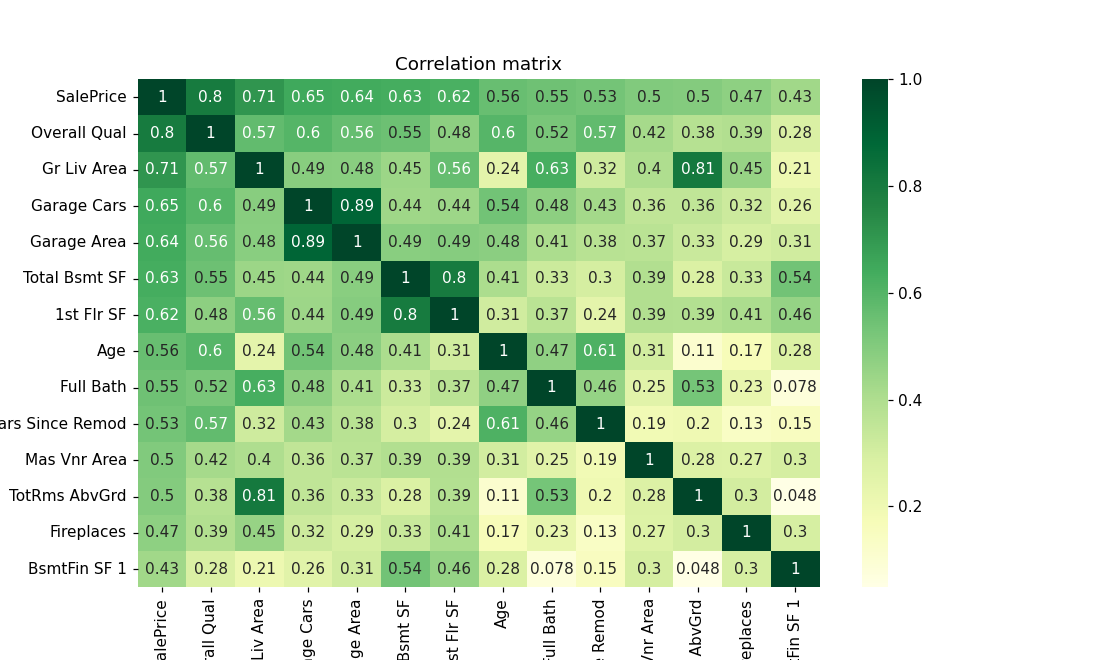

In [9]:
num_cols = price_cor[price_cor>.4].dropna().index

plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr().abs(), annot=True, cmap='YlGn')
plt.title('Correlation matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0);

Three pairs of features correlate a lot: 'TotRms AbvGrd' - 'Gr Liv Area', '1st Flr SF' - 'Total Bsmt SF' and 'Garage Area' - 'Garage Cars'. We'll drop one from each pair, leaving 'Gr Liv Area', '1st Flr SF' and 'Garage Area', as they seem more informative. The rest of features with correlation higher than 0.4 don't seem to be correlating one another too much.

In [10]:
drop_feat2 = ['TotRms AbvGrd', 'Total Bsmt SF', 'Garage Cars']
num_cols = num_cols.drop(drop_feat2)

### Now let's examin categorical features as well

We'll train random forest using categorical variables only, to estimate feature importances. Doing so multiple times and taking average values will reduce randomness.

In [11]:
all_dummied = pd.get_dummies(df.select_dtypes('object'))

tree = RandomForestRegressor(n_estimators=20)

importances = pd.DataFrame(np.zeros(len(all_dummied.columns)), index=all_dummied.columns)
for i in range(10):
    tree.fit(all_dummied, df['SalePrice'])
    importances[i] = tree.feature_importances_

importances['Mean feature importance'] = importances.mean(axis=1)

n=10
importances = (importances
               .drop([i for i in range(10)], axis=1)
               .sort_values('Mean feature importance', ascending=False)
               .iloc[:n])
display(importances)

,Mean feature importance
Bsmt Qual_Ex,0.249901
Exter Qual_TA,0.179013
Exter Qual_Gd,0.072947
Fireplace Qu_No,0.071046
Kitchen Qual_Ex,0.051829
Bsmt Qual_Gd,0.026387
Neighborhood_NoRidge,0.022850
Bsmt Exposure_Gd,0.013812
Bldg Type_1Fam,0.010947
Exter Qual_Ex,0.010100


In [12]:
cat_columns = (importances.index
               .str.extract('(?P<col>^.+)_', expand=True).col
               .unique())
display(cat_columns)

array(['Bsmt Qual', 'Exter Qual', 'Fireplace Qu', 'Kitchen Qual',
       'Neighborhood', 'Bsmt Exposure', 'Bldg Type'], dtype=object)

In [13]:
final_df = pd.merge(df[num_cols], pd.get_dummies(df[cat_columns]), left_index=True, right_index=True)

## Hyperparameter tuning

In [15]:
X = final_df.drop('SalePrice', axis=1)
y = final_df['SalePrice']

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=125)

rdg = Ridge()
param_grid = {'alpha': np.logspace(-3,2,6)}
grid = GridSearchCV(rdg, param_grid=param_grid, scoring='r2', cv=5)
grid.fit(X_trainval, y_trainval)

print('Best validation score: ',grid.best_score_)
print('Alpha: ', grid.best_params_['alpha'])

rdg = Ridge(alpha=grid.best_params_['alpha'])
rdg.fit(X_trainval, y_trainval)
y_pred = rdg.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('-'*30)
print('r2 score: ',r2)
print('rmse: ', rmse)


Best validation score:  0.865494051707788
Alpha:  0.1
------------------------------
r2 score:  0.8944580322989285
rmse:  23943.363326829927


Although r2 score between 0.85-0.9 isn't bad, one could try extensive feature engineering to get even better results on this data.